<div class="alert alert-info">
<h1><center><font color=darkblue> Exploring the Importance of Class Imbalance Handling Techniques on the prediction of Stroke .<font></center></h1>


</div>

   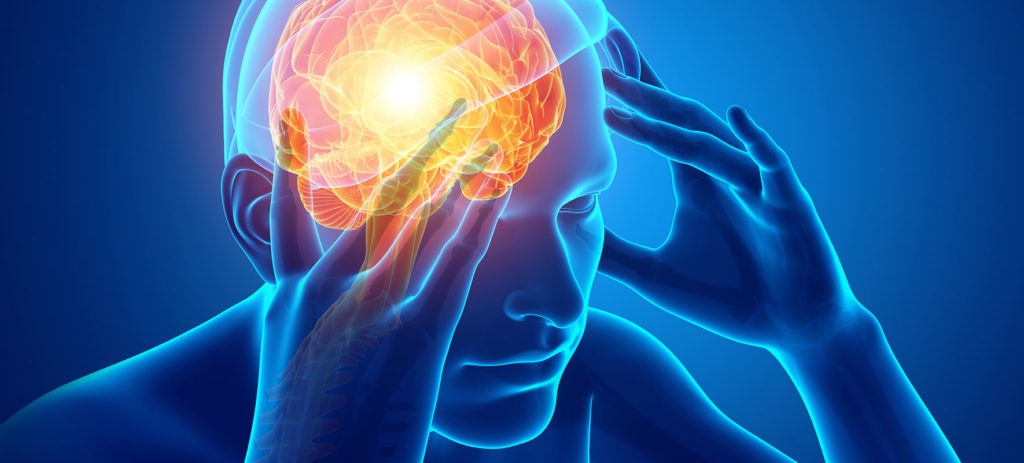


# <font color=RoyalBlue>1. Introduction<font>


### <font color=CornflowerBlue>Objective:<font>

A stroke is a serious life-threatening medical condition that happens when the blood supply to part of the brain is cut off. Strokes are a medical emergency and urgent treatment is essential. The sooner a person receives treatment for a stroke, the less damage is likely to happen.(NHS)

Like all organs, the brain needs the oxygen and nutrients provided by blood to function properly. If the supply of blood is restricted or stopped, brain cells begin to die. This can lead to brain injury, disability and possibly death. (NHS). This classification model will predict whether the patient has heart disease or not based on various conditions/symptoms of their body.




### <font color=CornflowerBlue>Dataset:<font>

In this project, I am going to use the *healthcare-dataset-stroke-data.csv* dataset from kaggle. The dataset is publically available on the Kaggle website, and it is from an ongoing cardiovascular study.  The classification goal is to predict whether the patient has Stroke or not. The dataset provides the patients’ information. It includes over 5,000 records and 12 attributes. The data contains 5110 observations with 12 attributes.

 The dataset contains 13 independent features and 1 target feature as described below.<br/>
> 1. age 
> 2. gender 
> 3. Hypertension (2 values) 
> 4. Heart Disease (2 Values)
> 5. Ever Married (2 values)
> 6. Work Type (4 values) 
> 7. Resident Type (values 0,1)
> 8. Average Glucose Level 
> 9. Body Mass Index
> 10. Smoking Status
> 11. Stroke - is the binary target variable, 0 indicates that the patient has stroke, the value is 1 if not.   

# <font color=RoyalBlue>2. Exploratory Data Analysis<font>

### <font color=CornflowerBlue>2.1 Import Library:<font>

In [ ]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
import random as rnd
from operator import add
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
import plotly.express as ex
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,roc_auc_score, r2_score
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas_profiling

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')



### <font color=CornflowerBlue>2.2 Prepare Data:<font>



In [ ]:
# Importing the data and checking the first five row of the data
stroke_raw = pd.read_csv('../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
stroke_raw.head()

In [ ]:
# Showing the last 5 rows of the data
stroke_raw.tail()

In [ ]:
# checking the shape of the raw dataset
stroke_raw.shape

From the shape above, we can see that we have 5110 rows (values) and 12 columns (features)

In [ ]:
# checking the size of the raw dataset
stroke_raw.size

### <font color=CornflowerBlue>2.3 Handling Missing Data:<font>

In [ ]:
# Profiling of Data
x=pandas_profiling.ProfileReport(stroke_raw)
x

In [ ]:
# print data characteristics, usings pandas built-in describe() function
stroke_raw.describe()

From the table above, we can see that the ranges between the values of the non-categorical features are wide. Then, Feature scaling has to be  performed. I will do this later*

Since Hypertension and heart disease are in binary classification, they shouldn't be shown among the description above. So, I will convert it to an object data type.

This is also necessary to decide the necessity for feature scaling

In [ ]:
# converting some data type to object
stroke_raw = stroke_raw.astype({'hypertension': 'int', 'heart_disease': 'int'})

In [ ]:
# crosscheck the dataset to identify the feature with missing value
print(stroke_raw.info())
missing_values = (stroke_raw.isnull().sum() / len(stroke_raw)) * 100
print("\nFeatures with missing values: \n", missing_values[missing_values > 0])

From Above, the size of the data is 479.2kb.
The dataset is made up of datatypes: floating point, Integer and object
We can see that BMI has some missing values. Then something need to be done about this later.

In [ ]:
# Explore the unique values of categorical features
print(np.char.center(" The Unique values of categorical variables ", 60, fillchar = "*"))
print("\nGender: ", stroke_raw.gender.unique())
print("Heart Disease: ", sorted(stroke_raw.heart_disease.unique()))
print("Smoking Status: ", sorted(stroke_raw.smoking_status.unique()))
print("Ever married: ", sorted(stroke_raw.ever_married.unique()))
print("work type: ", sorted(stroke_raw.work_type.unique()))
print("hypertension: ", sorted(stroke_raw.hypertension.unique()))
print("Residence type: ", sorted(stroke_raw.Residence_type.unique()))
print("Stroke: ", sorted(stroke_raw.stroke.unique()))

It is important to see here that the gender is not only male and female. There are also some people who never disclosed their smoking status. 

In [ ]:
# Checking for the features we have in the dataset to see if there are useless features
stroke_raw.columns

In [ ]:
# Drop the Id colomn since it is the only feature that won't be needed for the data processing
stroke_raw.drop('id', inplace=True, axis=1)

In [ ]:
# Check for any null values
stroke_raw.isnull().sum()

From above, Only "Bmi" has null value with 201 missing values

In [ ]:
# Finding out the percentage of missing values 
# In order to know if we can ignore, fill or eliminate the missing values
count=0
for i in stroke_raw.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Total number of rows with missing values is ', count)
print('Since the percentage of missing value is',round((count/len(stroke_raw.index))*100),'percent', 'I shouldnt drop them')

plt.title('Missing Value in Stroke Dataset',fontweight='bold')
ax = sns.heatmap(stroke_raw.isna().sum().to_frame(),annot=True,fmt='d',cmap='vlag')
ax.set_xlabel('Amount Missing')
plt.show()

Bmi seems like a very important features. So we must treat the missing values with care i.e., we can't drop it

In [ ]:
# We have known the colomn with missing value, let's Find the specific rows with missing data
stroke_raw.isnull().sum(axis = 1)

In [ ]:
# visualize the missing data in the dataset
sns.heatmap(stroke_raw.isnull(),yticklabels=False,cbar=False,cmap='viridis')

- Instead of filling the missing data with the mean or median or mode which might slightly affect the prediction, 
- I will use a simple Decision tree to plot get a more accurate randomized values,
- I will be using 3 features which are average glucose level, gender and the BMI whose datas are missing.

In [ ]:
# Constructing decision tree pipe for Bmi with missing data
# Setting the random_state to 42
# Then fill the missing values with the accurate randomized values

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier

pipe_bmi = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])
X = stroke_raw[['avg_glucose_level','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
pipe_bmi.fit(X,Y)
predicted_bmi = pd.Series(pipe_bmi.predict(Missing[['avg_glucose_level','gender']]),index=Missing.index)
stroke_raw.loc[Missing.index,'bmi'] = predicted_bmi

In [ ]:
# Plot to check if the data is now clean
sns.heatmap(stroke_raw.isnull(), cbar=False,cmap='viridis')

In [ ]:
# changing dataset name with a dummy dropna
stroke = stroke_raw.dropna()

In [ ]:
# plot for missing value status
plt.title('Missing Value Status',fontweight='bold')
ax = sns.heatmap(stroke.isna().sum().to_frame(),annot=True,fmt='d',cmap='vlag')
ax.set_xlabel('Amount Missing')
plt.show()

In [ ]:
# Rename the stroke colomn to target so as to avoid confusion when predicting
stroke.rename(columns={'stroke':'target'},inplace=True)

In [ ]:
# Check the head and tail of the dataset before proceeding to visualization
print(stroke.head())
print (stroke.tail())

#   <font color=RoyalBlue>3. Data Visualization <font>

In [ ]:
# Compare the stroke chances by counting the dependent variable and plot using pyplot
# Also, Calculate the percentage that had stroke or not

colors = ['darkturquoise', 'darkorange']
plt.style.use('default')
plt.rcParams['figure.figsize']=(12,6)

ax = sns.countplot(x='stroke', data=stroke_raw, palette=colors, alpha=0.9, edgecolor=('white'), linewidth=2)
ax.set_ylabel('count', fontsize=12)
ax.set_xlabel('target', fontsize=12)
ax.grid(b=True, which='major', color='grey', linewidth=0.2)
plt.title('The Stroke Chance', fontsize=18)
plt.show()

stroke_0 = len(stroke_raw[stroke_raw.stroke == 0])
stroke_1 = len(stroke_raw[stroke_raw.stroke == 1])
print("Percentage not Having stroke: {:.2f}%".format((stroke_0 / (len(stroke_raw.stroke))*100)))
print("Percentage Having stroke: {:.2f}%".format((stroke_1 / (len(stroke_raw.stroke))*100)))

Yikes. Only around 100 of patients are classified as stroke patients. This is a great way to make high-accuracy low-recall models and further inaccurate predictions.
Therefore, I can’t pass this type of dataset to a machine learning algorithm. 

### <font color=CornflowerBlue>3.1 Univariate Visualization:<font>

In [ ]:
# Using Histogram chart to Check the distribution of data across the features by implementing the function below:

def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='green')
        ax.set_title(feature+" Distribution",color='red')
        
    fig.tight_layout() 
    plt.style.use('default')
    plt.show()
draw_histograms(stroke,stroke.columns,6,3)

In [ ]:
# Now let's use a pie chart to get the exact percentage of the distribution 

# (1) First, Define the properties of the chart below, 

def draw_semi_pie_chart(data, column, fig, renamed_index_dict, title):
    default_colors = ['#66b3ff', '#ff9999', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#ff6666']
    rnd.shuffle(default_colors)
    ax = stroke[column].value_counts().rename(index = renamed_index_dict).plot.pie(colors = default_colors, autopct='%1.1f%%', startangle=90, title = title)
    ax.set_ylabel('')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
        
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    fig.gca().add_artist(centre_circle)

In [ ]:
# (2) Then, plot the chart one by one

fig = plt.gcf()
fig.set_size_inches(18, 17)
grid_rows = 3
grid_cols = 3

# Plot Gender Pie chart
plt.subplot(grid_rows, grid_cols, 1)
draw_semi_pie_chart(stroke, 'gender', fig, {0: 'Female', 1: 'Male'}, 'Gender Distribution')

# Plot Hypertension Pie chart
plt.subplot(grid_rows, grid_cols, 2)
draw_semi_pie_chart(stroke, 'hypertension', fig, {0: 'NO', 1: 'YES'}, 'Hypertension Distribution')

# Plot Marriage Pie chart
plt.subplot(grid_rows, grid_cols, 3)
draw_semi_pie_chart(stroke, 'ever_married', fig, {0: 'Not married', 1: 'Married'}, 'Married or Not')

# Plot Work Type Pie chart
plt.subplot(grid_rows, grid_cols, 4)
draw_semi_pie_chart(stroke, 'work_type', fig, {0: 'Never Worked', 1: 'Childeren', 2: 'Govt work', 3: 'self employed', 4: 'private' }, 'Work Type')

# Plot Residence Type Pie chart
plt.subplot(grid_rows, grid_cols, 5)
draw_semi_pie_chart(stroke, 'Residence_type', fig, {0: 'Urban', 1: 'Rural'}, 'Type of Residence')

# Plot Smoking Status Pie chart
plt.subplot(grid_rows, grid_cols, 6)
draw_semi_pie_chart(stroke, 'smoking_status', fig, {0: 'Unknown', 1: 'Smokes', 2: 'Never smokes', 3: 'Formally smokes', 4: 'private' }, 'smoking_status')
fig.tight_layout()
plt.show()

In [ ]:
fig = ex.histogram(stroke['bmi'],nbins=100, height=500, width=700, template='ggplot2')
fig.show()

In [ ]:
fig = ex.histogram(stroke['avg_glucose_level'],nbins=100, height=500, width=700, template='ggplot2')
fig.show()

In [ ]:
# Performing Label encoding on 'Residence_type' ,'ever_married' and 'gender'
stroke["Residence_type"] = stroke["Residence_type"].apply(lambda x: 1 if x=="Urban" else 0)
stroke["ever_married"] = stroke["ever_married"].apply(lambda x: 1 if x=="Yes" else 0)
stroke["gender"] = stroke["gender"].apply(lambda x: 1 if x=="Male" else 0)

In [ ]:
# Then plot the distribution of the encoded features
sns.distplot(stroke['gender'],rug=True)
plt.show()

sns.distplot(stroke['Residence_type'],rug=True)
plt.show()

sns.distplot(stroke['ever_married'],rug=True)
plt.show()

### <font color=CornflowerBlue>3.2 Bivariate Visualization:<font>

In [ ]:
# Plot the Gender vs target
import plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
col='gender'
d1=stroke[stroke['target']==0]
d2=stroke[stroke['target']==1]
v1=d1[col].value_counts().reset_index()
v1=v1.rename(columns={col:'count','index':col})
v1['percent']=v1['count'].apply(lambda x : 100*x/sum(v1['count']))
v1=v1.sort_values(col)
v2=d2[col].value_counts().reset_index()
v2=v2.rename(columns={col:'count','index':col})
v2['percent']=v2['count'].apply(lambda x : 100*x/sum(v2['count']))
v2=v2.sort_values(col)
trace1 = go.Bar(x=v1[col], y=v1["count"], name=0, marker=dict(color="#a678de"))
trace2 = go.Bar(x=v2[col], y=v2["count"], name=1, marker=dict(color="#6ad49b"))
data = [trace1, trace2]
layout={'title':"target over the gender(male or female)",'xaxis':{'title':"target"}}
#layout = go.Layout(title="Content added over the years", legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(data, layout=layout)
iplot(fig)

In [ ]:
# plot the target vs work type
col='work_type'
d1=stroke[stroke['target']==0]
d2=stroke[stroke['target']==1]
v1=d1[col].value_counts().reset_index()
v1=v1.rename(columns={col:'count','index':col})
v1['percent']=v1['count'].apply(lambda x : 100*x/sum(v1['count']))
v1=v1.sort_values(col)
v2=d2[col].value_counts().reset_index()
v2=v2.rename(columns={col:'count','index':col})
v2['percent']=v2['count'].apply(lambda x : 100*x/sum(v2['count']))
v2=v2.sort_values(col)
trace1 = go.Bar(x=v1[col], y=v1["count"], name=0, marker=dict(color="#a678de"))
trace2 = go.Bar(x=v2[col], y=v2["count"], name=1, marker=dict(color="#6ad49b"))
data = [trace1, trace2]
layout={'title':"target over the work type",'xaxis':{'title':"target"}}
#layout = go.Layout(title="Content added over the years", legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(data, layout=layout)
iplot(fig)

In [ ]:
# Plot the target vs the average glucose level
col='avg_glucose_level'
d1=stroke[stroke['target']==0]
d2=stroke[stroke['target']==1]
v1=d1[col].value_counts().reset_index()
v1=v1.rename(columns={col:'count','index':col})
v1['percent']=v1['count'].apply(lambda x : 100*x/sum(v1['count']))
v1=v1.sort_values(col)
v2=d2[col].value_counts().reset_index()
v2=v2.rename(columns={col:'count','index':col})
v2['percent']=v2['count'].apply(lambda x : 100*x/sum(v2['count']))
v2=v2.sort_values(col)
trace1 = go.Scatter(x=v1[col], y=v1["count"], name=0, marker=dict(color="#a678de"))
trace2 = go.Scatter(x=v2[col], y=v2["count"], name=1, marker=dict(color="#6ad49b"))
data = [trace1, trace2]
layout={'title':"Target over the person's average glucose level"}
fig = go.Figure(data, layout=layout)
iplot(fig)

### <font color=CornflowerBlue>3.3 Multivariate Visualization:<font>

In [ ]:
# Checking the relationship between Average glucose level, Bmi and ever_married
sns.lmplot(x="avg_glucose_level", y="bmi",data=stroke,hue="ever_married")
plt.show()

Either married or not, there are more people with lower average glucose leveland high Bmi than people with higher average glucose level and Low Bmi. 

Deduction From the Pie chart above :

1) We have more females than male
2) only 9.7% of the population has hypertension. 
3) More than 60% of the population is married
4) More than 50% of the population works in private sector
5) Urban and rural distribution of residency is almost shared equally
6) More than 30% of the population do not declare their smoking status but more people has never smoked

In [ ]:
# Tabulize the categorical vs Target
stroke_cat = stroke[['gender','Residence_type','ever_married','smoking_status','work_type', 'hypertension','heart_disease','target']]
cat_vs_target = pd.concat([pd.crosstab(stroke_cat[x], stroke_cat.target) for x in stroke_cat.columns[:-1]], keys = stroke_cat.columns[:-1])
cat_vs_target

In [ ]:
# (1) Plot the stroke frequency across the age range
pd.crosstab(stroke.age,stroke.target).plot(kind="bar",figsize=(20,6))
plt.title('Stroke Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# The chat below shows that stroke chances generally increases with age within the range of 45 to 82 years of age
# We can also see that at 78 years old, there are more stroke patients than any other age range

In [ ]:
# (2) Plot the stroke frequency in relation to BMI

stroke.loc[stroke['target'] == 0,
                 'bmi'].hist(label='No Stroke')
stroke.loc[stroke['target'] == 1,
                 'bmi'].hist(label=' There is Stroke')
plt.xlabel('BMI')
plt.ylabel('Stroke')
plt.legend()

# chances of stroke increses with bmi 20-40, and the rate at which there is no stroke is highest at BMI 19 to 38

In [ ]:
plt.subplot(2,1,1)
plt.title('Stroke Sample Distribution Based On Bmi And Glucose Level')
sns.scatterplot(x=stroke['avg_glucose_level'],y=stroke['bmi'],hue=stroke['target'])
plt.show()

In [ ]:
plt.subplot(2,1,2)
plt.title('Stroke Sample Distribution Based On Bmi And Age')
sns.scatterplot(x=stroke['age'],y=stroke['bmi'],hue=stroke['target'])
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
stroke.plot(kind='scatter', x='age', y='avg_glucose_level', alpha=0.5, color='blue', ax=axes[0], title="Age vs. avg_glucose_level")
stroke.plot(kind='scatter', x='bmi', y='avg_glucose_level', alpha=0.5, color='orange', ax=axes[1], title="bmi vs. avg_glucose_level")
plt.show()

#   <font color=RoyalBlue>4. Feature Engineering <font>

### <font color=CornflowerBlue>4.1 Change Data Type:<font>

In [ ]:
# Performing 'one hot encoding' on 'work_type' and 'smoking_status'
work = pd.get_dummies(stroke['work_type'],prefix='work_type',drop_first=True)
stroke=pd.concat([stroke,work],axis=1)
stroke.drop(['work_type'],axis=1,inplace=True)

smoking = pd.get_dummies(stroke['smoking_status'],prefix='smoking_status',drop_first=True)
stroke=pd.concat([stroke,smoking],axis=1)
stroke.drop(['smoking_status'],axis=1,inplace=True)



In [ ]:
# Re-explore the dataset to check the one hot encoding
stroke.head()

### <font color=CornflowerBlue>4.2 Check for Correlation:<font>

In [ ]:
# checking correlation by plotting
%matplotlib inline
plt.figure(figsize=(10,10))
sns.heatmap(stroke.corr(),annot=True,fmt='.1f')
plt.show()

From the correlation matrix, we can see that none of the features arrive at a significant correlation with the target feature. Only age has the highest with 0.2. 
Therefore, this matrix is not enough to arrive at a conclusion of features that can help in predicting stroke.
We will implement another method 

In [ ]:
# More deeper correlation check
stroke.corr()

From the numbers above, there is no significant correlation. Hence, I will have to generate important features with mutual information later

### <font color=CornflowerBlue>4.3 Scaling the Data :<font>

In [ ]:
# Rename Stroke
stroke_scaled = stroke

In [ ]:
# Scaling all values except the target variable = target

from sklearn.preprocessing import MinMaxScaler
MMscal=MinMaxScaler()
features=['age', 'gender', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']
stroke_scaled[features] = MMscal.fit_transform(stroke[features])

#Check first five rows after scaling
stroke_scaled.head()

In [ ]:
# Creating Features and Target variable as X and Y
X = stroke_scaled.drop('target', axis=1)
Y = stroke_scaled.target

#   <font color=RoyalBlue>5. Modelling and Feature Importance <font>

In this section, I will be performing 4 major steps which are 
- Modelling Using Imbalanced Raw stroke Data
- Modelling Using Balanced Stroke data (Random Undersampling)
- Modelling Using Balanced Stroke date (SMOTE)
- modelling Using Balanced Stroke Data (SMOTETomek)
This 4 Steps will be compared to pick the best algorithm that fit with the best Data

## <font color=Brown>5.1 Modelling Using Raw Data :<font>

### <font color=CornflowerBlue>5.1.1 Splitting the data into Train and Test :<font>



The last step before modelling is to split the data into train and test samples. The test set will be composed of 20% of the data.

I will use the train dataset to train the models and then evaluate them of the test set : 
<center><img src= "https://data-flair.training/blogs/wp-content/uploads/sites/2/2018/08/1-16.png">

To split the data, I will use train_test_split function from sklearn

In [ ]:
# Splitting the data into training and testing data sets
from sklearn.model_selection import train_test_split
X_train1,X_test1,y_train1,y_test1=train_test_split(X,Y,test_size=0.2 ,random_state=1)

### <font color=CornflowerBlue>5.1.2 Collect Mutual Information :<font>

In [ ]:
# Collecting Mutual Information for feature selection
from sklearn.feature_selection import mutual_info_regression
mutual_info1 = mutual_info_regression(X_train1, y_train1)
mutual_info1 = pd.Series(mutual_info1)
mutual_info1.index = X_train1.columns
mutual_info1 = mutual_info1.sort_values(ascending=False)
mutual_info1

Since we couldn't properly generate the best features for the training using correlation matrix, we will be using mutual information to generate the set of the best performing data for training. 

Hence, the mutual information (MI) of any two random variables is the measure of the mutual dependence between the two variables. 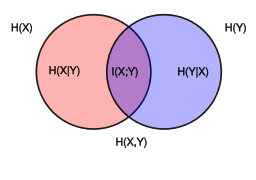

Frome the picture above, the violet area is the mutual information shared

In [ ]:
# Considering the columns for training the model which are more than 0% of information shared with dependent variable/feature
Req_Columns1 = list(mutual_info1[mutual_info1>0].index)
Req_Columns1

Only the 8 features above are fit for training based on the mutual information greater than zero shared with the target

In [ ]:
# Checking the first 5 row of training data
X_train_final_1 = X_train1[Req_Columns1]
X_train_final_1.head(5)

In [ ]:
# Checking the last 3 rows of X test data
X_test_final_1 = X_test1[Req_Columns1]
X_test_final_1.head(3)

In [ ]:
# Check Stroke Proportion of the Imbalanced Data
fig = ex.pie(stroke,names='target')
fig.update_layout(title='<b>Imbalance stroke proportion<b>')
fig.show()

### <font color=CornflowerBlue>5.1.3 Run the Algorithms :<font>

In [ ]:
# First, Define the first evaluation function for the first batches of algorithms as 'evaluation_1'

def evaluation_1(Y_test1,Y_pred1):
    acc_1=accuracy_score(Y_test1,Y_pred1)
    rcl_1=recall_score(Y_test1,Y_pred1)
    f1_1=f1_score(Y_test1,Y_pred1)
    auc_score_1 = roc_auc_score(Y_test1,Y_pred1)
    prec_score_1=precision_score(Y_test1,Y_pred1)
    
    metric_dict={'accuracy': round(acc_1*100,2),
               'recall': round(rcl_1*100,2),
               'F1 score': round(f1_1*100,2),
               'auc score': round(auc_score_1*100,2),
               'precision': round(prec_score_1*100,2)
                }
    
    return print(metric_dict)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> I. Applying K-Nearest Neighbour on unbalanced Data </h4> 

The k-nearest neighbors (KNN) algorithm is a basic supervised machine learning algorithm that can be used to solve both classification and regression problems. KNN works by exploiting the distances between a features and all the examples in the data, and select the specified number examples (K) closest to the feature, then votes for the most frequent label (in the case of classification) or averages the labels (in the case of regression).

In [ ]:
# Training KNN model 
np.random.seed(42) # Set the pseudo random number
KNC_model_1 =  KNeighborsClassifier() # Define the classifier

# Fit the model for prediction
KNC_model_1.fit(X_train_final_1,y_train1)

# make prediction on testing data   
KNC_model_y_pred_1=KNC_model_1.predict(X_test_final_1) 
KNC_model_r2_score_1=round(r2_score(y_test1,KNC_model_y_pred_1)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",KNC_model_r2_score_1)
print("Accuracy on Training set: ",round(KNC_model_1.score(X_train_final_1,y_train1)*100,2))
KNC_model_score_1 = round(KNC_model_1.score(X_test_final_1,y_test1)*100,2)
print("Accuracy on Testing set: ",KNC_model_score_1)
evaluation_1(y_test1,KNC_model_y_pred_1)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test1,KNC_model_y_pred_1),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> II. Applying Logistics Regression on unbalanced Data </h4> 

### <center> How Logistic regression works :

<center><img src= "https://saedsayad.com/images/LogReg_1.png">

In Logit Regression, input variable (x) are combined linearly using weights or coefficient values to predict an output variable (y). 
The key difference from linear regression is that the output value is a binary values (0 or 1) rather than a numeric value. Logistic regression is a linear method, but the predictions are transformed using the logistic function.
    
Logistic regression (LR) is a classification and regression analysis in statistics used for prediction of outcome of a categorical dependent variable from a set of independent variables. Therefore, it is a supervised learning algorithm.
Logistic regression relies on probability of success using the logistic (sigmoid) function. The term regression is very simple and it means any process that attempts to find relationships between variables. It is logistic because it uses logistic function as a link function.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Training Logistics model 
np.random.seed(42) # Set the pseudo random number
LR_model_1 = LogisticRegression() # Define the classifier

# Fit the model for prediction
LR_model_1.fit(X_train_final_1,y_train1)

# make prediction on testing data   
LR_model_y_pred_1 = LR_model_1.predict(X_test_final_1) 
LR_model_r2_score_1=round(r2_score(y_test1,KNC_model_y_pred_1)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",LR_model_r2_score_1)
print("Accuracy on Training set: ",round(LR_model_1.score(X_train_final_1,y_train1)*100,2))
LR_model_score_1 = round(LR_model_1.score(X_test_final_1,y_test1)*100,2)
print("Accuracy on Testing set: ",LR_model_score_1)
evaluation_1(y_test1,KNC_model_y_pred_1)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test1,LR_model_y_pred_1),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> III. Applying Random Forest Classifier on unbalanced Data </h4> 

The fundamental idea behind a random forest is to combine the predictions made by many decision trees into a single model. Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes or mean prediction of the individual trees

In [ ]:
# Training Random Forest model 
np.random.seed(42) # Set the pseudo random number
RFC_model_1=RandomForestClassifier() # Define the classifier

# Fit the model for prediction
RFC_model_1.fit(X_train_final_1,y_train1)

# make prediction on testing data   
RFC_model_y_pred_1 = RFC_model_1.predict(X_test_final_1) 
RFC_model_r2_score_1=round(r2_score(y_test1,RFC_model_y_pred_1)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",RFC_model_r2_score_1)
print("Accuracy on Training set: ",round(RFC_model_1.score(X_train_final_1,y_train1)*100,2))
RFC_model_score_1 = round(RFC_model_1.score(X_test_final_1,y_test1)*100,2)
print("Accuracy on Testing set: ",RFC_model_score_1)
evaluation_1(y_test1,RFC_model_y_pred_1)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test1,RFC_model_y_pred_1),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> IV. Applying Support Vector Machine on unbalanced Data </h4> 

### <center> How SVM works : </center>

<center><img src= "https://vitalflux.com/wp-content/uploads/2020/07/Screenshot-2020-07-07-at-3.44.38-PM.png">

A support vector machine (SVM) is a supervised machine learning model that uses classification algorithms for two-group classification problems. The objective of the SVM algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

In [ ]:
from sklearn.svm import SVC

# Training SVM model 
np.random.seed(42) # Set the pseudo random number
SVC_model_1=SVC() # Define the classifier

# Fit the model for prediction
SVC_model_1.fit(X_train_final_1,y_train1)

# make prediction on testing data   
SVC_model_y_pred_1 = SVC_model_1.predict(X_test_final_1) 
SVC_model_r2_score_1=round(r2_score(y_test1,SVC_model_y_pred_1)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",SVC_model_r2_score_1)
print("Accuracy on Training set: ",round(SVC_model_1.score(X_train_final_1,y_train1)*100,2))
SVC_model_score_1 = round(SVC_model_1.score(X_test_final_1,y_test1)*100,2)
print("Accuracy on Testing set: ",SVC_model_score_1)
evaluation_1(y_test1,SVC_model_y_pred_1)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test1,SVC_model_y_pred_1),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> V. Applying Extreme Gradient Boost on unbalanced Data </h4> 

# <center> How XGBoost works :</center>

![](https://d1rwhvwstyk9gu.cloudfront.net/2020/02/XG-Boost-FINAL-01.png)

The sequential ensemble methods, also known as “boosting”, creates a sequence of models that attempt to correct the mistakes of the models before them in the sequence. The first model is built on training data, the second model improves the first model, the third model improves the second, and so on. 
XGBoost provides an efficient and effective implementation of the gradient boosting algorithm

In [ ]:
np.random.seed(42) # Set the pseudo random number
from xgboost import XGBClassifier
XGB_model_1 = XGBClassifier()
XGB_model_1.fit(X_train_final_1,y_train1)
XGB_model_y_pred_1=XGB_model_1.predict(X_test_final_1)
XGB_model_r2_score_1=round(r2_score(y_test1,XGB_model_y_pred_1)*100,2)
print("R2 Score for predicted value: ",XGB_model_r2_score_1)
print("Accuracy on Training set: ",round(XGB_model_1.score(X_train_final_1,y_train1)*100,2))
XGB_model_score_1 = round(XGB_model_1.score(X_test_final_1,y_test1)*100,2)
print("Accuracy on Testing set: ",XGB_model_score_1)
evaluation_1(y_test1,XGB_model_y_pred_1)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test1,XGB_model_y_pred_1),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> VI. Applying Multilayer Perceptron on unbalanced Data </h4> 

### <center> How Neural network works : </center>

<center><img src= "https://victorzhou.com/27cf280166d7159c0465a58c68f99b39/network3.svg">

The h1, h2 and o1 which are the layers of the neural network are nodes. The function of a node is to pass the input from data and combine with set of coefficients and bias, that either amplify or dampen the input, then fix a  significance to  the inputsdepending on the type of algorithm the task is trying to learn. 
    
The input-weight products are summed and then passed to the activation function, to determine whether and to what extent that signal should progress further through the network to affect the ultimate outcome, which is the  classification mechanics. If the signals successfully passes through, the neuron has been “activated.”
    
MLP is a deep ANN and supervised algorithm which is made up of more than one perceptron. It is a feedforward model that generates output from an input data by training the network with backpropagation.

In [ ]:
from sklearn.neural_network import MLPClassifier

# Define the classification parameters
mlp_1 = MLPClassifier(hidden_layer_sizes=(300,300,300), max_iter=1000, alpha=0.00001,
                     solver='adam', verbose=10,  random_state=21)
# Fit the models
mlp_1.fit(X_train_final_1, y_train1)
mlp_pred_1= mlp_1.predict(X_test_final_1)

mlp_score_1 = mlp_1.score(X_train_final_1, y_train1)
mlp_test_1 = mlp_1.score(X_test_final_1, y_test1)
mlp_model_r2_score_1=round(r2_score(y_test1,mlp_pred_1)*100,2)

# Make predictions
y_pred_1 =mlp_1.predict(X_test_final_1)

#evaluation
cm = confusion_matrix(y_test1,y_pred_1)
print("R2 Score for predicted value: ",mlp_model_r2_score_1)
print('Training Score',mlp_score_1)
print('Testing Score \n',mlp_test_1)
print(cm)
evaluation_1(y_test1,mlp_pred_1)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test1,mlp_pred_1),annot=True,cbar=True)

## <font color=Purple>5.1.4 Extraction from the Algorithm Implementation :<font>

In [ ]:
# First Concatenate the accuracy Accuracy scores
summary_score1 = pd.DataFrame({'Applied_Model': ['Logistic Regression Raw', 'Random Forest Raw', 'K-Nearest Neighbour Raw', 'Support Vector Machine Raw', "Extreme Gradient Boost Raw", 'Multilayer Perceptron Raw'], 
                                'Accuracy_Score': [LR_model_score_1, RFC_model_score_1, KNC_model_score_1, SVC_model_score_1, XGB_model_score_1,mlp_test_1*100]})
summary_score1 = summary_score1.sort_values(by = ['Accuracy_Score'], ascending = False)
summary_score1

In [ ]:
# Define evaluation metrics for Logistic Regression as the best performing algorithm
LGR_final_metrics1 ={'Accuracy': LR_model_1.score(X_test_final_1,y_test1),
                   'Precision': precision_score(y_test1,LR_model_y_pred_1),
                   'Recall': recall_score(y_test1,LR_model_y_pred_1),
                   'F1': f1_score(y_test1,LR_model_y_pred_1),
                   'AUC': roc_auc_score(y_test1,LR_model_y_pred_1)}

LGR_metrics=pd.DataFrame(LGR_final_metrics1,index=[0])
LGR_metrics.T.plot.bar(title='Logistic Regression Metric Evaluation', color = 'black', legend=False);

As shown above, Logistic Regression performed best of all the algorithms. Also, all the algorithms achieved a negative R2 score including our best performing MLP. Logit regression and SVM achieved the same accuracy. Random forest has the least accuracy.

- Let's talk about the Negative R2 scores:

 Generally, 𝑅2  is computed as 1−𝑆𝑆res divided by 𝑆𝑆tot. (where the 𝑆𝑆𝑟𝑒𝑠 = residual error.) 

What 𝑅2 does is that it  basically compares the fit of the chosen model with that of a horizontal straight line (the null hypothesis). If the chosen model fits worse than a horizontal line, then 𝑅2 is negative

This means that most of the algorithms are fitting worse than the horizontal line. Which means the 𝑆𝑆res is greater than the 𝑆𝑆tot

- Bottom line: 

The negative 𝑅2 is not mathematically impossible. It just means that the chosen model (with its constraints) fits the data really poorly. 

- So what can I do?

I will investigate the best AUC score  

I will see if handling of Imbalance Data can solve the issue of poorly fit

##### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> Investigating the best performing AUC (Random Forest) </h4> 

In [ ]:
# Find the Area under curve
from sklearn import metrics
y_pred_rfc_proba1 = RFC_model_1.predict_proba(X_test_final_1)[::,1]
fpr_rfc, tpr_rfc, _ = metrics.roc_curve(y_test1,  y_pred_rfc_proba1)
auc_rfc = metrics.roc_auc_score(y_test1, y_pred_rfc_proba1)
print("AUC RFC :", auc_rfc)

In [ ]:
# plot the ROC curve of the AUC
plt.plot(fpr_rfc,tpr_rfc,label="RFC, auc={:.3f})".format(auc_rfc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Random Forest ROC curve')
plt.legend(loc=4)
plt.show()

 # <h2 style="text-align: left; font-family: 'Garamond'; font-size:30px; color:Purple">Handling Imbalanced Dataset</h2>

## <font color=Brown>5.2 Modelling Using Random Undersampled Data :<font>

In [ ]:
# Define the dictionary for listing
accuracies_under = dict()
recall_under = dict()

In [ ]:
# Splitting the data into training and testing data sets
from sklearn.model_selection import train_test_split
X_train2,X_test2,y_train2,y_test2=train_test_split(X,Y,test_size=0.2 ,random_state=1)

In [ ]:
# Show the count of the target Before Applying Random UNDER Sampling

one_count = 0
zero_count = 0

for i in y_train2:
    if i == 1:
        one_count +=1
    else:
        zero_count +=1
        
print('Number of one count before applying RandomUnder Sampler is: ', one_count)
print('Number of zero count before applying RandomUnder Sampler is: ', zero_count)


From above, we can see that the target is highly imbalance. This is a challenge because our classifiers will always be forced predict the most common class without performing any accurate prediction of the features and it will have a h. So what is the way forward? Random undersampling.  

Although this method is simple and effective, the limitation of RU is that Some features are removed without any concern for their importance and their effect in determining the decision boundary between the classes. This means it is possible, or even likely, that useful information will be deleted.

### <center>How undersampling works :</center>
<center><img src= "https://miro.medium.com/max/335/1*YH_vPYQEDIW0JoUYMeLz_A.png">



To perform random undersample, we can use the package imblearn with RandomUnderSampler function !

In [ ]:
# Import the package and perform undersampling on the data 
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(sampling_strategy= 0.6)

X_train2, y_train2 = under.fit_resample(X_train2, y_train2)

In [ ]:
#  Now, let us check the data After Applying Random UnderSampling
one_count = 0
zero_count = 0

for i in y_train2:
    if i == 1:
        one_count +=1
    else:
        zero_count +=1
        
print('Number of one count after applying RandomUnder Sampler is: ', one_count)
print('Number of zero count after applying RandomUnder Sampler is: ', zero_count)

In [ ]:
# plot to show target after Random Undersampling 
fig = ex.pie(y_train2,names='target')
fig.update_layout(title='<b>Stroke Proportion After Random Undersampling<b>')
fig.show()

In [ ]:
# Collect Mutual Information for the data to be used for Train and Test
from sklearn.feature_selection import mutual_info_regression
mutual_info2 = mutual_info_regression(X_train2, y_train2)
mutual_info2 = pd.Series(mutual_info1)
mutual_info2.index = X_train2.columns
mutual_info2 = mutual_info2.sort_values(ascending=False)
mutual_info2

In [ ]:
# Considering the columns for training the model which are more than 0% of information shared with dependent variable/feature
Req_Columns2 = list(mutual_info2[mutual_info2>0].index)
Req_Columns2

Only the 8 features above will be selected for training and testing the algorithms based on mutual information collected after persorming Random Undersampling

In [ ]:
# Define the training set 
X_train_final_2 = X_train2[Req_Columns2]
X_train_final_2.head(5)

In [ ]:
# Define the testing set
X_test_final_2 = X_test2[Req_Columns1]
X_test_final_2.head(3)

In [ ]:
# Define the evaluation function for the  new Algorithm implementation

def evaluation_2(Y_test2,Y_pred2):
    acc_2=accuracy_score(Y_test2,Y_pred2)
    rcl_2=recall_score(Y_test2,Y_pred2)
    f1_2=f1_score(Y_test2,Y_pred2)
    auc_score_2 = roc_auc_score(Y_test2,Y_pred2)
    prec_score_2=precision_score(Y_test2,Y_pred2)
    
    metric_dict={'accuracy': round(acc_2*100,2),
               'recall': round(rcl_2*100,2),
               'F1 score': round(f1_2*100,2),
               'auc score': round(auc_score_2*100,2),
               'precision': round(prec_score_2*100,2)
                }
    
    return print(metric_dict)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> I. Applying K-Nearest Neighbour on Random Undersampled Data </h4> 

In [ ]:
# Training KNN model 
np.random.seed(42) # Set the pseudo random number
KNC_model_2 =  KNeighborsClassifier() # Define the classifier

# Fit the model for prediction
KNC_model_2.fit(X_train_final_2,y_train2)

# make prediction on testing data   
KNC_model_y_pred_2=KNC_model_2.predict(X_test_final_2) 
KNC_model_r2_score_2=round(r2_score(y_test2,KNC_model_y_pred_2)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",KNC_model_r2_score_2)
print("Accuracy on Training set: ",round(KNC_model_2.score(X_train_final_2,y_train2)*100,2))
KNC_model_score_2 = round(KNC_model_2.score(X_test_final_2,y_test2)*100,2)
print("Accuracy on Testing set: ",KNC_model_score_2)
evaluation_2(y_test2,KNC_model_y_pred_2)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test2,KNC_model_y_pred_2),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> II. Applying Logistics Regression on Random Undersampled Data</h4> 

In [ ]:
# Training Logistics model 
np.random.seed(42) # Set the pseudo random number
LR_model_2 = LogisticRegression() # Define the classifier

# Fit the model for prediction
LR_model_2.fit(X_train_final_2,y_train2)

# make prediction on testing data   
LR_model_y_pred_2 = LR_model_2.predict(X_test_final_2) 
LR_model_r2_score_2=round(r2_score(y_test2,LR_model_y_pred_2)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",LR_model_r2_score_2)
print("Accuracy on Training set: ",round(LR_model_2.score(X_train_final_2,y_train2)*100,2))
LR_model_score_2 = round(LR_model_2.score(X_test_final_2,y_test2)*100,2)
print("Accuracy on Testing set: ",LR_model_score_2)
evaluation_2(y_test2,LR_model_y_pred_2)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test2,LR_model_y_pred_2),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> III. Applying Random Forest on Random Undersampled Data </h4> 

In [ ]:
# Training Random Forest model 
np.random.seed(42) # Set the pseudo random number
RFC_model_2 = RandomForestClassifier() # Define the classifier

# Fit the model for prediction
RFC_model_2.fit(X_train_final_2,y_train2)

# make prediction on testing data   
RFC_model_y_pred_2 = RFC_model_2.predict(X_test_final_2) 
RFC_model_r2_score_2=round(r2_score(y_test2,RFC_model_y_pred_2)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",RFC_model_r2_score_2)
print("Accuracy on Training set: ",round(RFC_model_2.score(X_train_final_2,y_train2)*100,2))
RFC_model_score_2 = round(RFC_model_2.score(X_test_final_2,y_test2)*100,2)
print("Accuracy on Testing set: ",RFC_model_score_2)
evaluation_2(y_test2,RFC_model_y_pred_2)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test2,RFC_model_y_pred_2),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> IV. Applying SVN on Random Undersampled Data </h4> 

In [ ]:
# Training SVM model 
np.random.seed(42) # Set the pseudo random number
SVC_model_2=SVC() # Define the classifier

# Fit the model for prediction
SVC_model_2.fit(X_train_final_2,y_train2)

# make prediction on testing data   
SVC_model_y_pred_2 = SVC_model_2.predict(X_test_final_2) 
SVC_model_r2_score_2=round(r2_score(y_test2,SVC_model_y_pred_2)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",SVC_model_r2_score_2)
print("Accuracy on Training set: ",round(SVC_model_2.score(X_train_final_2,y_train2)*100,2))
SVC_model_score_2 = round(SVC_model_2.score(X_test_final_2,y_test2)*100,2)
print("Accuracy on Testing set: ",SVC_model_score_2)
evaluation_2(y_test2,SVC_model_y_pred_2)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test2,SVC_model_y_pred_2),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> V. Applying MLP on Random Undersampled Data </h4> 

In [ ]:
# Define the parameters
mlp_2 = MLPClassifier(hidden_layer_sizes=(300,300,300), max_iter=1000, alpha=0.00001,
                     solver='adam', verbose=10,  random_state=21)
# Fit the models
mlp_2.fit(X_train_final_2, y_train2)
mlp_pred_2= mlp_2.predict(X_test_final_2)

mlp_score_2 = round(mlp_2.score(X_train_final_2, y_train2)*100,2)
mlp_test_2 = mlp_2.score(X_test_final_2, y_test2)
mlp_model_r2_score_2=round(r2_score(y_test2,mlp_pred_2)*100,2)


# Make predictions
y_pred_2 =mlp_2.predict(X_test_final_2)

#evaluation
print("R2 Score for predicted value: ",mlp_model_r2_score_2)
print('Training Score',mlp_score_2)
print('Testing Score \n',mlp_test_2)

evaluation_2(y_test2,mlp_pred_2)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test2,mlp_pred_2),annot=True,cbar=True)

## <font color=Purple> 5.2.4 Extraction from the Algorithm Implementation :<font>

In [ ]:
# Concatenate the accuracies of the algorithms
summary_score2 = pd.DataFrame({'Applied_Model': ['Logistic Regression Rand', 'Random Forest Rand', 'K-Nearest Neighbour Rand', 'Support Vector Machine Rand', 'Multilayer Perceptron Rand'], 
                                'Accuracy_Score': [LR_model_score_2, RFC_model_score_2, KNC_model_score_2, SVC_model_score_2,mlp_test_2*100]})
summary_score2 = summary_score2.sort_values(by=['Accuracy_Score'], ascending=False)
summary_score2

In [ ]:
# Define evaluation metrics for Logistic Regression as the best performing algorithm
LGR_final_metrics2 ={'Accuracy': LR_model_2.score(X_test_final_2,LR_model_y_pred_2),
                   'Precision': precision_score(y_test2,LR_model_y_pred_2),
                   'Recall': recall_score(y_test2,LR_model_y_pred_2),
                   'F1': f1_score(y_test2,LR_model_y_pred_2),
                   'AUC': roc_auc_score(y_test2,LR_model_y_pred_2)}

LGR_metrics2 = pd.DataFrame(LGR_final_metrics2,index=[0])
LGR_metrics2.T.plot.bar(title='Logistic Regression Metric Evaluation', color = 'blue', legend=False);

- Bottom line: 

The negative 𝑅2 is still obvious after undersampling. It just means that the chosen model (with its constraints) fits the data really poorly even after handling the imbalance. 

- So what can I do?

I will see if SMOTE can solve the issue of poorly fit

In [ ]:
# Find the Area under curve
from sklearn import metrics
y_pred_LR_proba2 = LR_model_2.predict_proba(X_test_final_2)[::,1]
fpr_LR, tpr_LR, _ = metrics.roc_curve(y_test2,  y_pred_LR_proba2)
auc_LR = metrics.roc_auc_score(y_test2, y_pred_LR_proba2)
print("AUC LR :", auc_LR)

In [ ]:
# plot the ROC curve of the AUC
plt.plot(fpr_rfc,tpr_rfc,label="LR, auc={:.3f})".format(auc_rfc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistics Regression ROC curve')
plt.legend(loc=4)
plt.show()

## <font color=Brown >5.3 Modelling Using SMOTE Data :<font>

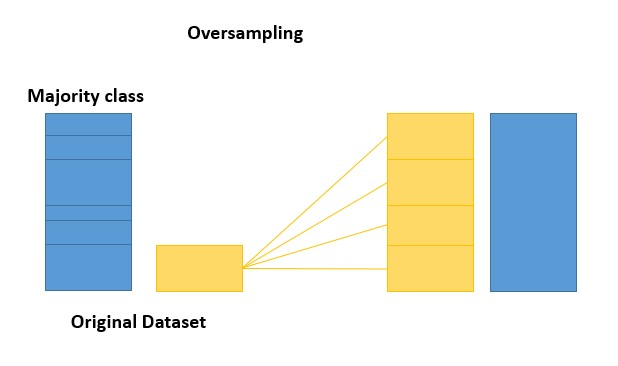



SMOTE (Synthetic Minority Oversampling technique) is a method that generates synthetic samples from the minority class. It is used to obtain a synthetically class-balanced or nearly class-balanced training set, which is then used to train the classifier.

In [ ]:
# Performing smote on the original data
sm = SMOTE(random_state=123)
X_sm , Y_sm = sm.fit_resample(X,Y)

print(f'''Shape of X before SMOTE:{X.shape}
Shape of X after SMOTE:{X_sm.shape}''',"\n\n")

print(f'''Target Class distributuion before SMOTE:\n{Y.value_counts(normalize=True)}
Target Class distributuion after SMOTE :\n{Y_sm.value_counts(normalize=True)}''')

From above,
- the target class before Smote is 0.9:0.1
- After SMOTE, we have 0.5:0.5

In [ ]:
# plot to show target after performing SMOTE 
fig = ex.pie(Y_sm,names='target')
fig.update_layout(title='<b>Stroke Proportion After Smote Sampling<b>')
fig.show()

In [ ]:
# splitting the data into training and testing data sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_sm,Y_sm,test_size=0.2 ,random_state=1)

In [ ]:
# Getting Mutual Informations
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info = mutual_info.sort_values(ascending=False)
mutual_info

In [ ]:
# Considering the columns for training the model which are more than 0% of information shared with dependent variable/feature
Req_Columns = list(mutual_info[mutual_info>0].index)
Req_Columns

Only the features above are useful for the algorthm

In [ ]:
# Get the final training set
X_train_final = X_train[Req_Columns]
X_train_final.head(5)

In [ ]:
# Get the final Test set
X_test_final = X_test[Req_Columns]
X_test_final.head(3)

In [ ]:
# Define the Evaluation metrics for the Algorthm
def evaluation(Y_test,y_pred):
    acc=accuracy_score(y_test,y_pred)
    rcl=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    auc_score=roc_auc_score(y_test,y_pred)
    prec_score=precision_score(y_test,y_pred)
    
    metric_dict={'accuracy': round(acc*100,2),
               'recall': round(rcl*100,2),
               'F1 score': round(f1*100,2),
               'auc score': round(auc_score*100,2),
               'precision': round(prec_score*100,2)
                }
    
    return print(metric_dict)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> I. Applying KNN on Oversampled Data </h4> 

In [ ]:
# Training KNN model
np.random.seed(42) # Set the pseudo random number
KNC_model=  KNeighborsClassifier() # Define the classifier
KNC_model.fit(X_train_final,y_train) # Fit the model
KNC_model_y_pred=KNC_model.predict(X_test_final) # make prediction on testing data
KNC_model_r2_score=round(r2_score(y_test,KNC_model_y_pred)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",KNC_model_r2_score)
print("Accuracy on Training set: ",round(KNC_model.score(X_train_final,y_train)*100,2))
KNC_model_score = round(KNC_model.score(X_test_final,y_test)*100,2)
print("Accuracy on Testing set: ",KNC_model_score)
evaluation(y_test,KNC_model_y_pred)

The Accuracy with  K Nearest Neighbor is 91.11%. This is a good performance but lower than the taining accuracy. Also note the positivity in the R2 score. Which means a good fitting

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test,KNC_model_y_pred),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> II. Applying LGR on Oversampled Data </h4>  

In [ ]:
from sklearn.linear_model import LogisticRegression
np.random.seed(42)
LR_model=LogisticRegression()
LR_model.fit(X_train_final,y_train)
LR_model_y_pred=LR_model.predict(X_test_final)
LR_model_r2_score=round(r2_score(y_test,LR_model_y_pred)*100,2)
print("R2 Score for predicted value: ",LR_model_r2_score)
print("Accuracy on Training set: ",round(LR_model.score(X_train_final,y_train)*100,2))
LR_model_score = round(LR_model.score(X_test_final,y_test)*100,2)
print("Accuracy on Testing set: ",LR_model_score)
evaluation(y_test,LR_model_y_pred)

Logistic regression has an accuracy of 78.56% Accuracy of the logistic regression is poor compared to KNN

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test,LR_model_y_pred),annot=True,cbar=True)

# <h3 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:Brown"> Explore Feature Importance using Logistic Regression</h3> 

In [ ]:
# Check the relevance of feature by checking the coeficients
coef = LR_model.coef_[0]
coef = [abs(number) for number in coef]
print(coef)

From above, the coefficients ranges from app (0.23 to 7.37). Next step is to find the specific feature with the highest to lowest.

In [ ]:
# First, arrange the colomn
cols = list(stroke_scaled.columns)
cols.index('target')

# Remove the target label 
del cols[8]
cols

In [ ]:
# Then arrange the colomn based on importance
sorted_index = sorted(range(len(coef)), key = lambda k: coef[k], reverse = True)
for idx in sorted_index:
    print(cols[idx])

From above, gender has the highest coefficient while bmi has the lowest

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> III. Applying Random Forest on Oversampled Data </h4>  

In [ ]:
# Training the model
np.random.seed(42)
RFC_model=RandomForestClassifier()
RFC_model.fit(X_train_final,y_train)
RFC_model_y_pred=RFC_model.predict(X_test_final)
RFC_model_r2_score=round(r2_score(y_test,RFC_model_y_pred)*100,2)

# Print the accuracy and evaluation
print("R2 Score for predicted value: ",RFC_model_r2_score)
print("Accuracy on Training set: ",round(RFC_model.score(X_train_final,y_train)*100,2))
RFC_model_score = round(RFC_model.score(X_test_final,y_test)*100,2)
print("Accuracy on Testing set: ",RFC_model_score)
evaluation(y_test,RFC_model_y_pred)

The Random forest Algorithm perform better with an accuracy of 94.6%

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test,RFC_model_y_pred),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> IV. Applying SVM on Oversampled Data </h4>   

In [ ]:
from sklearn.svm import SVC
np.random.seed(42)
SVC_model=SVC()
SVC_model.fit(X_train_final,y_train)
SVC_model_y_pred=SVC_model.predict(X_test_final)
SVC_model_r2_score=round(r2_score(y_test,SVC_model_y_pred)*100,2)
print("R2 Score for predicted value: ",SVC_model_r2_score)
print("Accuracy on Training set: ",round(SVC_model.score(X_train_final,y_train)*100,2))
SVC_model_score = round(SVC_model.score(X_test_final,y_test)*100,2)
print("Accuracy on Testing set: ",SVC_model_score)
evaluation(y_test,SVC_model_y_pred)

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test,SVC_model_y_pred),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> V. Applying Xgboost on Oversampled Data </h4>   

In [ ]:
from xgboost import XGBClassifier
XGB_model=XGBClassifier()
XGB_model.fit(X_train_final,y_train)
XGB_model_y_pred=XGB_model.predict(X_test_final)
XGB_model_r2_score=round(r2_score(y_test,XGB_model_y_pred)*100,2)
print("R2 Score for predicted value: ",XGB_model_r2_score)
print("Accuracy on Training set: ",round(XGB_model.score(X_train_final,y_train)*100,2))
XGB_model_score = round(XGB_model.score(X_test_final,y_test)*100,2)
print("Accuracy on Testing set: ",XGB_model_score)
evaluation(y_test,XGB_model_y_pred)

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test,XGB_model_y_pred),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> VI. Applying MLP on Oversampled Data </h4>   

In [ ]:
from sklearn.neural_network import MLPClassifier

# Define the parameters
mlp=MLPClassifier(hidden_layer_sizes=(300,300,300), max_iter=1000, alpha=0.00001,
                     solver='adam', verbose=10,  random_state=21)
# Fit the models
mlp.fit(X_train_final, y_train)
mlp_pred= mlp.predict(X_test_final)

mlp_score = mlp.score(X_train_final, y_train)
mlp_test = mlp.score(X_test_final, y_test)

# Make predictions
y_pred =mlp.predict(X_test_final)

#evaluation
cm = confusion_matrix(y_test,y_pred)
print('Training Score',mlp_score)
print('Testing Score \n',mlp_test)
print(cm)
evaluation(y_test,mlp_pred)

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test,mlp_pred),annot=True,cbar=True)

In [ ]:
# Compare the Accuracy scores
summary_score = pd.DataFrame({'Applied_Model': ['Logistic Regression smote', 'Random Forest smote', 'K-Nearest Neighbour smote', 'Support Vector Machine smote', "Extreme Gradient Boost smote", 'Multilayer Perceptron smote'], 
                                'Accuracy_Score': [LR_model_score, RFC_model_score, KNC_model_score, SVC_model_score, XGB_model_score,mlp_test*100]})
summary_score = summary_score.sort_values(by=['Accuracy_Score'], ascending=False)
summary_score

## <h2 style="text-align: left; font-family: 'Garamond'; font-size:25px; color:Brown"> 5.4 Investigating why XGB performed better than others </h2> 

In [ ]:
# Find the Area under curve
from sklearn import metrics
y_pred_xgb_proba = XGB_model.predict_proba(X_test_final)[::,1]
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_test,  y_pred_xgb_proba)
auc_xgb = metrics.roc_auc_score(y_test, y_pred_xgb_proba)
print("AUC XGB :", auc_xgb)

In [ ]:
# plot the ROC curve
plt.plot(fpr_xgb,tpr_xgb,label="XGB, auc={:.3f})".format(auc_xgb))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Extreme Gradient Boost ROC curve')
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, y_pred_xgb_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(xgb_recall, xgb_precision, color='orange', label='XGB')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

In [ ]:
# Checking the cross validation score ON XGB to get best score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(XGB_model, X_train_final, y_train, cv = 10)
print("Scores: ", scores)
print("Accuracy: ", round(scores.mean(), 2) * 100, "%")
print("Standard Deviation: +/-", scores.std())

Classification metrics for Multi Layer Perceptron (rounded down) :
- Accuracy : 96.0
- AUC : 97.9
- Standard deviation: +/- 0.0045356875389769204

I will Check If any of the Algorithms can be tuned to perform better than this accuracy

## <h1 style="text-align: left; font-family: 'Garamond'; font-size:25px; color:brown"> 5.5 Fine Tunning other Models</h1>

### <h2 style="text-align: left; font-family: 'Garamond'; font-size:25px; color:purple">1. Fine Tunning KNN on Oversampled Data</h2> 

#### <h3 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:teal">Manual Fine Tunning of KNN </h3>

In [ ]:
j = range(1, 31) # Set range from 1 to 30

# Setup algorithm
knc_model = KNeighborsClassifier()
knc_count=1
score_final = 0
# Loop through different neighbors values
for i in j:
    knc_model.set_params(n_neighbors = i) # set neighbors value
    score = round(knc_model.fit(X_train_final, y_train).score(X_test_final,y_test)*100,2)
    if score > score_final:
        score_final = score
        knc_count = i
    # Fit the algorithm
    #print(f"Accuracy with {i} no. of neighbors: {score}%")
print('Best n_neighbors is: ' + str(knc_count) + ', with accuracy score of ' + str(score_final) +'%')

With Manual Fine Tunning, KNN increased from 89.7 to 92.8%. That is awesome

In [ ]:
# Train and test after manual Fine tuning
np.random.seed(42)
from sklearn.neighbors import KNeighborsClassifier
KNC_model=  KNeighborsClassifier(n_neighbors=knc_count)
KNC_model.fit(X_train_final,y_train)
KNC_model_y_pred=KNC_model.predict(X_test_final)
KNC_model_r2_score=round(r2_score(y_test,KNC_model_y_pred)*100,2)
print("R2 Score for predicted value: ",KNC_model_r2_score)
print("Accuracy on Training set: ",round(KNC_model.score(X_train_final,y_train)*100,2))
KNC_model_score_mannual = round(KNC_model.score(X_test_final,y_test)*100,2)
print("Accuracy on Testing set: ",KNC_model_score_mannual)
evaluation(y_test,KNC_model_y_pred)

# <h3 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:teal">Hyperparameter tunning for  KNeighborsClassifier/(K-Nearest Neighbour) using GridSearchCV</h3>

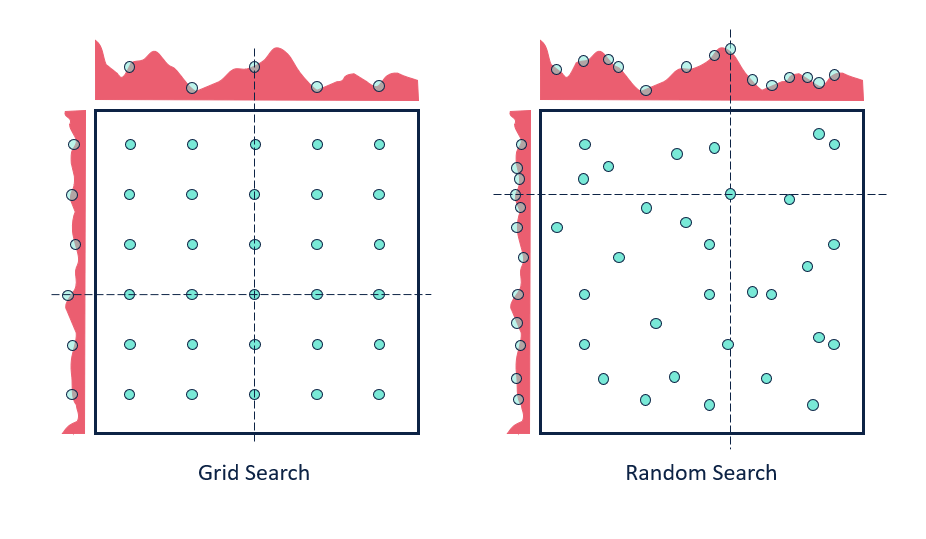
hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm (Wikipaedia)

- Grid search is arguably the most basic hyperparameter tuning method. With this technique, we simply build a model for each possible combination of all of the hyperparameter values provided, evaluating each model, and selecting the architecture which produces the best results.(Kdnudgets)




In [ ]:
from sklearn.model_selection import GridSearchCV
knn_param_grid={'n_neighbors': np.arange(1,31,1),
          'leaf_size': np.arange(1,31,1)}

knn_gs_model=GridSearchCV(KNeighborsClassifier(),param_grid=knn_param_grid,cv=3,verbose=True)

knn_gs_model.fit(X_train_final, y_train)

In [ ]:
# Fit the best parameter from the grid search
knn_gs_model.best_params_

In [ ]:
# Print the best result
best_results = pd.DataFrame(knn_gs_model.best_params_, index=[0])
best_results

In [ ]:
# Train and testing after GridsearchCV
np.random.seed(42)
from sklearn.neighbors import KNeighborsClassifier
KNC_model=  KNeighborsClassifier(n_neighbors=best_results.n_neighbors[0], leaf_size = best_results.leaf_size[0] )
KNC_model.fit(X_train_final,y_train)
KNC_model_y_pred=KNC_model.predict(X_test_final)
KNC_model_r2_score=round(r2_score(y_test,KNC_model_y_pred)*100,2)
print("R2 Score for predicted value: ",KNC_model_r2_score)
print("Accuracy on Training set: ",round(KNC_model.score(X_train_final,y_train)*100,2))
KNC_model_score_gs = round(KNC_model.score(X_test_final,y_test)*100,2)
print("Accuracy on Testing set: ",KNC_model_score_gs)
evaluation(y_test,KNC_model_y_pred)

In [ ]:
# Picking the best between the manual and gridsearchcv optimization
KNC_model_score2 =max(KNC_model_score_gs, KNC_model_score_mannual)
KNC_model_score2

Accuracy didn't improve above 92.8%

### <h2 style="text-align: left; font-family: 'Garamond'; font-size:25px; color:purple">2. Fine Tunning RandomForest on Oversampled Data</h2> 

In [ ]:
# Find the best N estimator for manual fine tunning of Random Forest
np.random.seed(42)
rf_count=1
score_final = 0
rfc_model = RandomForestClassifier()
#checked once till 50, still found the best estimator at 7, so decresed the range to 10 for future runs
for i in range(1,10,1):
    #print(f"With {i} estimators:")
    rfc_model=rfc_model.set_params(n_estimators=i*10,max_depth=i,random_state=i)
    score = round(rfc_model.fit(X_train_final, y_train).score(X_test_final,y_test)*100,2)
    if score > score_final:
        score_final = score
        rf_count = i*10
    #print(f"Accuracy: {clf2.score(X_test_final,y_test)*100:2f}%")
print('Best n_estimators is: ' + str(rf_count) + ', with accuracy score of ' + str(score_final) +'%')

In [ ]:
# Train and Test with the best n estimator
np.random.seed(42)
RFC_model=RandomForestClassifier(n_estimators=rf_count, max_depth=(rf_count/10),random_state=int(rf_count/10))
RFC_model.fit(X_train_final,y_train)
RFC_model_y_pred=RFC_model.predict(X_test_final)
RFC_model_r2_score=round(r2_score(y_test,RFC_model_y_pred)*100,2)
print("R2 Score for predicted value: ",RFC_model_r2_score)
print("Accuracy on Training set: ",round(RFC_model.score(X_train_final,y_train)*100,2))
RFC_model_score2 = round(RFC_model.score(X_test_final,y_test)*100,2)
print("Accuracy on Testing set: ",RFC_model_score2)
evaluation(y_test,RFC_model_y_pred)

### <h2 style="text-align: left; font-family: 'Garamond'; font-size:25px; color:purple">3. Fine Tunning XGboost on Oversampled Data using Randomized SearchCV</h2> 

- Random Search sets up a grid of hyperparameter values and selects random combinations to train the model and score. This allows to explicitly control the number of parameter combinations that are attempted. The number of search iterations is set based on time or resources. Scikit Learn offers the RandomizedSearchCV function for this process.(Kdnudgets)

In [ ]:
# Fitting 5 folds for each of 10 candidates, totalling 50 fits to Find the best parameters
from sklearn.model_selection import RandomizedSearchCV
learning_rate = [0.01, 0.1]
max_depth = [int(x) for x in np.linspace(5, 40, num = 6)]
min_child_weight = [int(x) for x in np.linspace(1, 20, num = 6)]
subsample =  [0.5, 0.7]
colsample_bytree = [0.5, 0.7]
objective = ['reg:squarederror']
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 2000, num = 40)]
gamma = [0.6, 0.7]
seed = [27]
reg_lambda = [2]
booster = ['dart']
colsample_bylevel = [0.6]
colsample_bynode = [0.5]
random_grid_param = {'learning_rate': learning_rate,
               'max_depth': max_depth,
               'min_child_weight': min_child_weight,
               'subsample': subsample,
               'colsample_bytree': colsample_bytree,
               'objective': objective,
               'n_estimators': n_estimators,
               'gamma': gamma,
               'seed' : seed,
               'reg_lambda' : reg_lambda,
               'booster' : booster,
               'colsample_bylevel' : colsample_bylevel,
               'colsample_bynode' : colsample_bynode}


XGB_rg_model = RandomizedSearchCV(estimator = XGB_model, param_distributions = random_grid_param,scoring='neg_mean_squared_error',
                               n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

XGB_rg_model.fit(X_train_final,y_train)

In [ ]:
# Revealing the best parameters for the optimized extreme gradient boost
XGB_rg_model.best_params_

In [ ]:
# creating dataframe for the best parameters
best_results_XGB = pd.DataFrame(XGB_rg_model.best_params_, index=[0])
best_results_XGB

In [ ]:
# Train and test with the parameters
XGB_model=XGBClassifier(subsample= best_results_XGB.subsample[0], 
                        seed= best_results_XGB.seed[0], 
                        reg_lambda= best_results_XGB.reg_lambda[0],
                        objective= best_results_XGB.objective[0],
                        n_estimators= best_results_XGB.n_estimators[0],
                        min_child_weight= best_results_XGB.min_child_weight[0],
                        max_depth= best_results_XGB.max_depth[0],
                        learning_rate= best_results_XGB.learning_rate[0],
                        gamma= best_results_XGB.gamma[0],
                        colsample_bytree= best_results_XGB.colsample_bytree[0],
                        colsample_bynode= best_results_XGB.colsample_bynode[0],
                        colsample_bylevel= best_results_XGB.colsample_bylevel[0],
                        booster= best_results_XGB.booster[0])
XGB_model.fit(X_train_final,y_train)
XGB_model_y_pred=XGB_model.predict(X_test_final)
XGB_model_r2_score=round(r2_score(y_test,XGB_model_y_pred)*100,2)
print("R2 Score for predicted value: ",XGB_model_r2_score)
print("Accuracy on Training set: ",round(XGB_model.score(X_train_final,y_train)*100,2))
XGB_model_score2 = round(XGB_model.score(X_test_final,y_test)*100,2)
print("Accuracy on Testing set: ",XGB_model_score2)
evaluation(y_test,XGB_model_y_pred)

### <h2 style="text-align: left; font-family: 'Garamond'; font-size:25px; color:purple">5. Fine Tunning SVM on Oversampled Data</h2> 

In [ ]:
# defining parameter range 
param_grid = {'C': [0.1, 1,2, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf','linear']}  
  
svc_gs_model = GridSearchCV(SVC(), param_grid,cv=5, refit = True, verbose = 3) 
  
# fitting the model for grid search 
svc_gs_model.fit(X_train_final, y_train)

In [ ]:
# print the tunning parameters and accuracy score
print(svc_gs_model.best_params_)
print(f"Accuracy score:{svc_gs_model.score(X_test_final,y_test)}%")

In [ ]:
# Create dataframe for the parameter above for fitting prediction
best_results_SVC = pd.DataFrame(svc_gs_model.best_params_, index=[0])
best_results_SVC

In [ ]:
# Train and test the new prediction after tunning SVC by supplying the parameters
np.random.seed(42)
SVC_model=SVC(C= best_results_SVC.C[0], gamma= best_results_SVC.gamma[0], kernel= best_results_SVC.kernel[0])
SVC_model.fit(X_train_final,y_train)
SVC_model_y_pred=SVC_model.predict(X_test_final)
SVC_model_r2_score=round(r2_score(y_test,SVC_model_y_pred)*100,2)
print("R2 Score for predicted value: ",SVC_model_r2_score)
print("Accuracy on Training set: ",round(SVC_model.score(X_train_final,y_train)*100,2))
SVC_model_score2 = round(SVC_model.score(X_test_final,y_test)*100,2)
print("Accuracy on Testing set: ",SVC_model_score2)
evaluation(y_test,SVC_model_y_pred)

### <h2 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:purple">Evaluation After Tunning</h2>

In [ ]:
# dataframe with accuracy score before tunning
summary_score

In [ ]:
# creating dataframe with accuracy score after tunning
all_model_score_tunned = pd.DataFrame({'Applied_Model': ['Logistic Regression sm_tunned', 'Random Forest sm_Tunned', 'K-Nearest Neighbour sm_Tunned', 
                                                      'Support Vector Machine sm_Tunned',"Extreme Gradient Boost sm_Tunned"], 
                                'Accuracy_Score': [LR_model_score, RFC_model_score2, KNC_model_score2, SVC_model_score2, XGB_model_score2]})
all_model_score_tunned = all_model_score_tunned.sort_values(by=['Accuracy_Score'], ascending=False)
all_model_score_tunned

In [ ]:
# Concatinating both the before and after tunning model accuracy
all_model_score_final = pd.concat([all_model_score_tunned, summary_score],0)
all_model_score_final = all_model_score_final.sort_values(by=['Accuracy_Score'], ascending=False)
all_model_score_final

In [ ]:
# Removing duplicate value of Logistic Regression
all_model_score_final = all_model_score_final.drop_duplicates()
all_model_score_final

When compared to how MLP performed on undersampled data, this is a great progress. 

## <font color=Brown >5.4 Modelling Using SMOTETomek Data :<font>

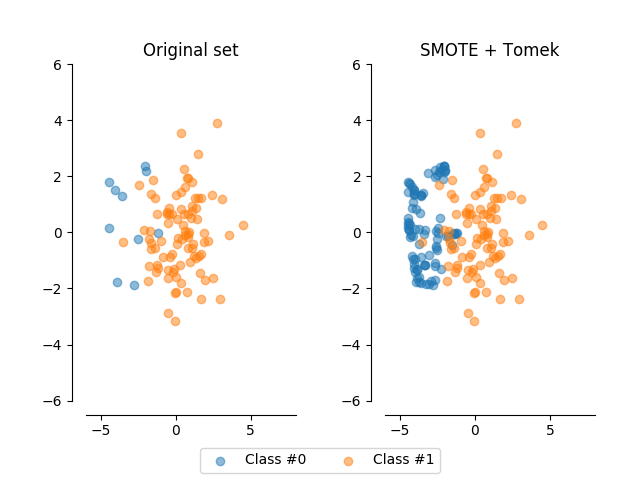
This method shown in the diagram above combines the SMOTE ability to generate synthetic data for minority class and Tomek Links ability to remove the data that are identified as Tomek links from the majority class (that is, samples of data from the majority class that is closest with the minority class data)

In [ ]:
# Define some dictionaries
accuracies_tomek = dict()
recall_tomek = dict()

In [ ]:
# Split the dataset into new training and testing data
X_train3, X_test3, y_train3, y_test3 = train_test_split(X,Y, random_state=22, test_size=0.2, shuffle=True)

In [ ]:
# Target count Before applying SMOTE Tomek

one_count = 0
zero_count = 0

for i in y_train3:
    if i==1:
        one_count +=1
    else:
        zero_count +=1
        
print('Number of one after applying SMOTE Tomek is: ', one_count)
print('Number of zero after applying SMOTE Tomek is: ', zero_count)

In [ ]:
# Import and fit SMote tomek
from imblearn.combine import SMOTETomek
combine = SMOTETomek()

X_train3, y_train3 = combine.fit_resample(X_train3, y_train3)

In [ ]:
# Target count After applying SMOTE Tomek

one_count = 0
zero_count = 0

for i in y_train3:
    if i==1:
        one_count +=1
    else:
        zero_count +=1
        
print('Number of one after applying SMOTE Tomek is: ', one_count)
print('Number of zero after applying SMOTE Tomek is: ', zero_count)

In [ ]:
# plot to show target after SMOTE Tomek
fig = ex.pie(y_train3,names='target')
fig.update_layout(title='<b>Stroke Proportion After SmoteTOTEK<b>')
fig.show()

In [ ]:
# Get Mutual Information 
from sklearn.feature_selection import mutual_info_regression
mutual_info_3 = mutual_info_regression(X_train3, y_train3)
mutual_info_3 = pd.Series(mutual_info_3)
mutual_info_3.index = X_train.columns
mutual_info_3 = mutual_info_3.sort_values(ascending=False)
mutual_info_3

In [ ]:
# Considering the columns for training the model which are more than 0% of information shared with dependent variable/feature
Req_Columns_3 = list(mutual_info_3[mutual_info_3 > 0].index)
Req_Columns_3

In [ ]:
# Create the final Train data and check first five rows
X_train_final_3 = X_train3[Req_Columns_3]
X_train_final_3.head(5)

In [ ]:
# Create the final Test data and check first 3 rows
X_test_final_3 = X_test3[Req_Columns_3]
X_test_final_3.head(3)

In [ ]:
# Define the evaluation metrics
def evaluation3(Y_test3,y_pred3):
    acc=accuracy_score(y_test3,y_pred3)
    rcl=recall_score(y_test3,y_pred3)
    f1=f1_score(y_test3,y_pred3)
    auc_score=roc_auc_score(y_test3,y_pred3)
    prec_score=precision_score(y_test3,y_pred3)
    
    metric_dict={'accuracy': round(acc*100,2),
               'recall': round(rcl*100,2),
               'F1 score': round(f1*100,2),
               'auc score': round(auc_score*100,2),
               'precision': round(prec_score*100,2)
                }
    
    return print(metric_dict)

# <h2 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green">1. Applying KNeighborsClassifier (K-Nearest Neighbour) after SmoteTotek </h2> 

In [ ]:
# Training KNN model
np.random.seed(42) # Set the pseudo random number
KNC_model_3=  KNeighborsClassifier() # Define the classifier
KNC_model_3.fit(X_train_final_3,y_train3) # Fit the model
KNC_model_y_pred_3=KNC_model_3.predict(X_test_final_3) # make prediction on testing data
KNC_model_r2_score_3=round(r2_score(y_test3,KNC_model_y_pred_3)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",KNC_model_r2_score)
print("Accuracy on Training set: ",round(KNC_model_3.score(X_train_final_3,y_train3)*100,2))
KNC_model_score_3 = round(KNC_model_3.score(X_test_final_3,y_test3)*100,2)
print("Accuracy on Testing set: ",KNC_model_score_3)
evaluation3(y_test3,KNC_model_y_pred_3)

  With a positive r2 score, KNN is showing a prospect of having a good performance. let us try to perform some tuning using GridsearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_neighbors': np.arange(1, 10)}
grid_search = GridSearchCV(estimator = KNC_model_3, param_grid = parameters, scoring = 'accuracy', cv = 10, n_jobs = -1)
grid_search = grid_search.fit(X_train_final_3, y_train3)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Score: ", best_accuracy)
print("Best Params: ", best_parameters)

With GridSearchCV, KNN algorithm increase to 95.6%. Impressive!

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test3,KNC_model_y_pred_3),annot=True,cbar=True)

# <h2 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green">2. Applying Logistics Regression after SmoteTotek </h2> 

In [ ]:
# Training Logistics model 
np.random.seed(42) # Set the pseudo random number
LR_model_3 = LogisticRegression() # Define the classifier

# Fit the model for prediction
LR_model_3.fit(X_train_final_3,y_train3)

# make prediction on testing data   
LR_model_y_pred_3 = LR_model_3.predict(X_test_final_3) 
LR_model_r2_score_3=round(r2_score(y_test3,KNC_model_y_pred_3)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",LR_model_r2_score_3)
print("Accuracy on Training set: ",round(LR_model_3.score(X_train_final_3,y_train3)*100,2))
LR_model_score_3 = round(LR_model_3.score(X_test_final_3,y_test3)*100,2)
print("Accuracy on Testing set: ",LR_model_score_3)
evaluation3(y_test3,LR_model_y_pred_3)

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test3,LR_model_y_pred_3),annot=True,cbar=True)

Highly negative R2 and lower training accuracy value shows that model does not fit for the dataset. Therefore, there is no need for hyperparameter optimization

# <h2 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green">3. Applying Random Forest after SmoteTotek </h2> 

In [ ]:
# Training Random Forest model 
np.random.seed(42) # Set the pseudo random number
RFC_model_3 = RandomForestClassifier() # Define the classifier

# Fit the model for prediction
RFC_model_3.fit(X_train_final_3,y_train3)

# make prediction on testing data   
RFC_model_y_pred_3 = RFC_model_3.predict(X_test_final_3) 
RFC_model_r2_score_3=round(r2_score(y_test3,RFC_model_y_pred_3)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",RFC_model_r2_score_3)
print("Accuracy on Training set: ",round(RFC_model_3.score(X_train_final_3,y_train3)*100,3))
RFC_model_score_3 = round(RFC_model_3.score(X_test_final_3,y_test3)*100,2)
print("Accuracy on Testing set: ",RFC_model_score_3)
evaluation3(y_test3,RFC_model_y_pred_3)

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test3,RFC_model_y_pred_3),annot=True,cbar=True)

Highly negative R2 but higher training accuracy value shows that model does not fit for the dataset. Therefore, there is no need for hyperparameter tuning

# <h2 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green">4. Applying Support Vector Machine after SmoteTotek </h2> 

In [ ]:
# Training SVM model 
np.random.seed(42) # Set the pseudo random number
SVC_model_3=SVC() # Define the classifier

# Fit the model for prediction
SVC_model_3.fit(X_train_final_3,y_train3)

# make prediction on testing data   
SVC_model_y_pred_3 = SVC_model_3.predict(X_test_final_3) 
SVC_model_r2_score_3=round(r2_score(y_test3,SVC_model_y_pred_3)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",SVC_model_r2_score_3)
print("Accuracy on Training set: ",round(SVC_model_3.score(X_train_final_3,y_train3)*100,2))
SVC_model_score_3 = round(SVC_model_3.score(X_test_final_3,y_test3)*100,2)
print("Accuracy on Testing set: ",SVC_model_score_3)
evaluation3(y_test3,SVC_model_y_pred_3)

Highly negative R2 and poor training accuracy value shows that model does not fit for the dataset. Therefore, there is no need for hyperparameter

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test3,SVC_model_y_pred_3),annot=True,cbar=True)

# <h2 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green">5. Applying Xgboost after SmoteTotek </h2> 

In [ ]:
XGB_model_3=XGBClassifier()
XGB_model_3.fit(X_train_final_3,y_train3)
XGB_model_y_pred_3=XGB_model_3.predict(X_test_final_3)
XGB_model_r2_score_3=round(r2_score(y_test,XGB_model_y_pred)*100,2)
print("R2 Score for predicted value: ",XGB_model_r2_score_3)
print("Accuracy on Training set: ",round(XGB_model_3.score(X_train_final_3,y_train3)*100,2))
XGB_model_score_3 = round(XGB_model_3.score(X_test_final_3,y_test3)*100,2)
print("Accuracy on Testing set: ",XGB_model_score_3)
evaluation3(y_test3,XGB_model_y_pred_3)

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test3,XGB_model_y_pred_3),annot=True,cbar=True)

Only XGboost and KNN fit the data perfectly. All others are pooly fit. Let us check MLP algorithms

# <h2 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green">6. Applying MLP after SmoteTotek </h2> 

In [ ]:

# Define the parameters
mlp_3 = MLPClassifier(hidden_layer_sizes=(300,300,300), max_iter=1000, alpha=0.00001,
                     solver='adam', verbose=10,  random_state=21)

# Fit the models
mlp_3.fit(X_train_final_3, y_train3)
mlp_pred_3= mlp_3.predict(X_test_final_3)

mlp_score_3 = round(mlp_3.score(X_train_final_3, y_train3)*100,2)
mlp_test_3 = mlp_3.score(X_test_final_3, y_test3)
mlp_3_r2_score_1=round(r2_score(y_test3,mlp_pred_3)*100,2)

# Make predictions
y_pred_3 =mlp_3.predict(X_test_final_3)

#evaluation
cm = confusion_matrix(y_test3,y_pred_3)
print("R2 Score for predicted value: ",mlp_3_r2_score_1)
print('Training Score',mlp_score_3)
print('Testing Score \n',mlp_test_3)
print(cm)
evaluation3(y_test3,mlp_pred_3)

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(y_test3,mlp_pred_3),annot=True,cbar=True)

In [ ]:
summary_score3 = pd.DataFrame({'Applied_Model': ['Logistic Regression Tomek', 'Random Forest Tomek', 'K-Nearest Neighbour Tomek', 'Support Vector Machine Tomek', "Extreme Gradient Boost Tomek", 'Multilayer Perceptron Tomek'], 
                                'Accuracy_Score': [LR_model_score_3, RFC_model_score_3, KNC_model_score_3, SVC_model_score_3, XGB_model_score_3,mlp_test_3*100]})
summary_score3 = summary_score3.sort_values(by=['Accuracy_Score'], ascending=False)
summary_score3

# <font color=RoyalBlue>6. Conclusion<font>

###  <font color=RoyalBlue>6.1. Compare The Accuracies Across the Steps using Bar plot<font>

In [ ]:
# A plot to compare the accuracy of the models applied
f, ax = plt.subplots(figsize=(8, 6))
sns.set_color_codes('pastel')
sns.barplot(y ='Applied_Model', x ='Accuracy_Score', data = summary_score1, color='gold', edgecolor='black')
plt.title('Accuracy Score Before Using Any Imbalance Data Handling Technique', fontsize=18)
plt.show()

In [ ]:
# A plot to compare the accuracy of the models applied
f, ax = plt.subplots(figsize=(8, 6))
sns.set_color_codes('pastel')
sns.barplot(y ='Applied_Model', x ='Accuracy_Score', data = summary_score2, color='Red', edgecolor='black')
plt.title('Accuracy Score After using Random Undersampling', fontsize=18)
plt.show()

In [ ]:
# A plot to compare the accuracy of the models applied
f, ax = plt.subplots(figsize=(8, 6))
sns.set_color_codes('pastel')
sns.barplot(y ='Applied_Model', x ='Accuracy_Score', data = summary_score, color='Green', edgecolor='black')
plt.title('Accuracy Score After using Smote', fontsize=18)
plt.show()

In [ ]:
# A plot to compare the accuracy of the models applied
f, ax = plt.subplots(figsize=(8, 6))
sns.set_color_codes('pastel')
sns.barplot(y ='Applied_Model', x ='Accuracy_Score', data = summary_score3, color='purple', edgecolor='black')
plt.title('Accuracy Score After using SmoteTomek', fontsize=18)
plt.show()

From the bar plots above, SMote MLP Algorithm performed best

### <font color=RoyalBlue>6.2. How Does XGB from SMOTE performed best?<font>

In [ ]:
# Concatinating all model accuracy
results = pd.concat([all_model_score_final,summary_score1,summary_score2,summary_score3],0)

In [ ]:
# Arrange Models in descending order
results.sort_values(by='Accuracy_Score', ascending=False)

From above, XGB used with SMOTE achieved a feat accuracy of 95.8%

In [ ]:
# Plot evaluation metrics for  best performing Xgboost
xgb_final_metrics ={'Accuracy': XGB_model.score(X_test_final,y_test),
                     'Precision': precision_score(y_test,XGB_model_y_pred),
                     'Recall': recall_score(y_test,XGB_model_y_pred),
                     'F1': f1_score(y_test,XGB_model_y_pred),
                     'AUC': roc_auc_score(y_test,XGB_model_y_pred)}

xgb_metrics=pd.DataFrame(xgb_final_metrics,index=[0])
xgb_metrics.T.plot.bar(title='XG boost Metric Evaluation', color = '#0a417a', legend=False);

In [ ]:
# Find the Area under curve
y_pred_xgb_proba2 = XGB_model_3.predict_proba(X_test_final_3)[::,1]
fpr_xgb2, tpr_xgb2, _ = metrics.roc_curve(y_test3,  y_pred_xgb_proba2)
auc_xgb2 = metrics.roc_auc_score(y_test3, y_pred_xgb_proba2)
print("AUC XGB_Tomek :", auc_xgb2)

In [ ]:
# plot the ROC curve
plt.plot(fpr_xgb2,tpr_xgb2,label="XGB, auc={:.3f})".format(auc_xgb2))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Extreme Gradient Boost for Smote Tomek ROC curve')
plt.legend(loc=4)
plt.show()

# <font color=RoyalBlue>7. Comparing our best Accuracy with Deep Neural Network<font>

In [ ]:
# Using the SMOTE data, Check the shape of the data
X_train_final.shape

In [ ]:
# Build the layers and train the model
model = Sequential()
model.add(Dense(32, input_shape=(15,), activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(16, activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(8, activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(4, activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the Model
opt = tf.keras.optimizers.Adam(learning_rate=0.001) #optimizer

model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy']) #metrics

In [ ]:
# Set early stopper 
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, verbose=1,mode='auto', baseline=None, restore_best_weights=False)

In [ ]:
# Fit the Model
history = model.fit(X_train_final.values, y_train.values, epochs = 6, batch_size=5, validation_split = 0.15, verbose = 0,
                    callbacks = [earlystopper])
history_dict = history.history

In [ ]:
# Plot the training loss and the validation training loss
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'b',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.legend()
plt.xlabel("Epochs")

In [ ]:
# Plot the accuracy and the validation Accuracy
accuracy_values = history_dict['accuracy']
val_accuracy_values=history_dict['val_accuracy']
plt.plot(val_accuracy_values,'-r',label='val_accuracy')
plt.plot(accuracy_values,'-b',label='accuracy')
plt.legend()
plt.xlabel("Epochs")

In [ ]:
# Make predictions on the test set
y_pred_nn = model.predict_classes(X_test_final)

In [ ]:
# Print the prediction scores
print("Accuracy Neural Net:",metrics.accuracy_score(y_test, y_pred_nn))
print("Precision Neural Net:",metrics.precision_score(y_test, y_pred_nn))
print("Recall Neural Net:",metrics.recall_score(y_test, y_pred_nn))
print("F1 Score Neural Net:",metrics.f1_score(y_test, y_pred_nn))


In [ ]:
# Plot the Confusion Matrix
matrix_nn = confusion_matrix(y_test, y_pred_nn)
cm_nn = pd.DataFrame(matrix_nn, index=['no_stroke', 'stroke'], columns=['no_stroke', 'stroke'])

sns.heatmap(cm_nn, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix Neural Network"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [ ]:
# Calculate the AUC Score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred_nn_proba = model.predict_proba(X_test_final)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test,y_pred_nn_proba)
auc_keras = auc(fpr_keras, tpr_keras)
print('AUC Neural Net: ', auc_keras)

In [ ]:
# Plot the ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Neural Net ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
nn_precision, nn_recall, _ = precision_recall_curve(y_test, y_pred_nn_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(nn_recall, nn_precision, color='orange', label='Keras NN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

- The Xtreme Gradient Boost has the best performance when used with SMOTE according to my four most important classification metrics which are Accuracy, R2 score, F1-score and AUC. XGboost also performed very well.

- The KNN from sklearn is the one that minimizes the most the false negatives.  so I decided to keep this model to predict Stroke. It's very important that a physician do not miss strokes so minimizing false negatives rate is very essential. 
